## Import libraries


In [1]:
import os
from glob import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = "Times New Roman"

import warnings

warnings.filterwarnings("ignore")

WORK_DIR = "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/"
os.chdir(WORK_DIR)
MAIN_DATA_DIR = "/beegfs/halder/DATA/"
PHENO_DATA_DIR = "/beegfs/halder/GITHUB/RESEARCH/land-surface-phenology/data/phenology_processed_(DE)_all"
OUT_DIR = os.path.join(WORK_DIR, "output")

## Read the dataset


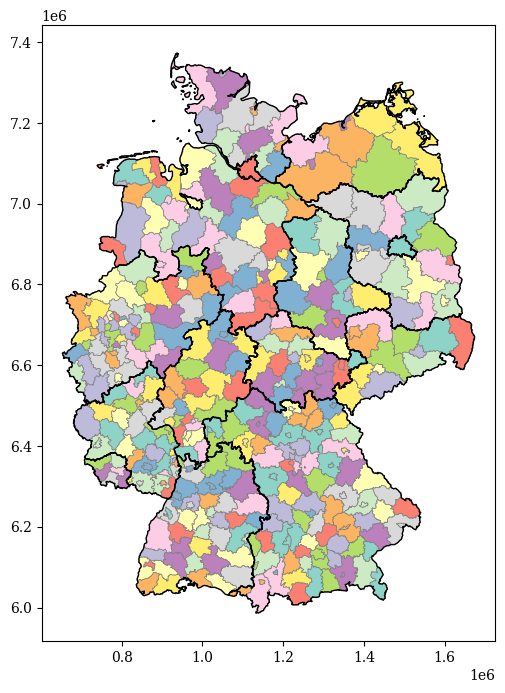

(16, 6) (400, 6)


,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,geometry
0,DE11B,3,DE,Main-Tauber-Kreis,Main-Tauber-Kreis,"POLYGON ((1074230.536 6408356.046, 1073820.827..."
1,DE11C,3,DE,Heidenheim,Heidenheim,"MULTIPOLYGON (((1131091.261 6235073.568, 11312..."
2,DE11D,3,DE,Ostalbkreis,Ostalbkreis,"MULTIPOLYGON (((1141777.678 6284962.486, 11412..."
3,DE121,3,DE,"Baden-Baden, Stadtkreis","Baden-Baden, Stadtkreis","MULTIPOLYGON (((910859.613 6248068.047, 913127..."
4,DE122,3,DE,"Karlsruhe, Stadtkreis","Karlsruhe, Stadtkreis","POLYGON ((938225.711 6286986.826, 940668.057 6..."


In [2]:
# Read the NUTS1 and NUTS3 shapefile for DE
de_nuts1_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, "DE_NUTS", "DE_NUTS_3.shp"))
de_nuts1_gdf = de_nuts1_gdf[
    de_nuts1_gdf["LEVL_CODE"] == 1
]  # filter only NUT1 level code
de_nuts1_gdf.rename(
    columns={"NUTS_ID": "STATE_ID", "NUTS_NAME": "STATE_NAME"}, inplace=True
)

de_nuts3_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, "DE_NUTS", "DE_NUTS_3.shp"))
de_nuts3_gdf = de_nuts3_gdf[
    de_nuts3_gdf["LEVL_CODE"] == 3
]  # filter only NUT3 level code

fig, ax = plt.subplots(figsize=(8, 8))
de_nuts3_gdf.plot(
    ax=ax,
    column="NUTS_NAME",
    cmap="Set3",
    edgecolor="grey",
    linewidth=0.5,
    label="NUTS3",
)
de_nuts1_gdf.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1, label="NUTS1")
plt.show()

print(de_nuts1_gdf.shape, de_nuts3_gdf.shape)
de_nuts3_gdf.head()

## Process the phenology data


In [3]:
def process_phenology(crop):
    phen_data_path = os.path.join(PHENO_DATA_DIR, f"phenology_({crop})_(DE).csv")
    phen_coords_paths = "/beegfs/halder/GITHUB/RESEARCH/land-surface-phenology/data/phenology_processed_(DE)_all/phenology_stations_(DE).gpkg"

    phen_data = pd.read_csv(phen_data_path, parse_dates=["date"])
    phen_coords = gpd.read_file(phen_coords_paths)
    phen_coords = phen_coords.to_crs("EPSG:3035")

    harvest_next_year = [
        "winter_wheat",
        "winter_rapeseed",
        "winter_barley",
        "winter_rye",
    ]

    # Sowing
    sowing_df = phen_data[phen_data["phase"] == "sowing"]
    sowing_df = sowing_df.rename(
        columns={"date": "sowing_date", "julian_day": "sowing_doy"}
    )
    sowing_df["harvest_year"] = (
        sowing_df["reference_year"] + 1
        if crop in harvest_next_year
        else sowing_df["reference_year"]
    )

    # Emergence
    emergence_df = phen_data[phen_data["phase"] == "emergence"]
    emergence_df = emergence_df.rename(
        columns={"date": "emergence_date", "julian_day": "emergence_doy"}
    )
    emergence_df["harvest_year"] = (
        emergence_df["reference_year"] + 1
        if crop in harvest_next_year
        else emergence_df["reference_year"]
    )

    # Flowering
    flowering_df = phen_data[phen_data["phase"] == "flowering"]
    flowering_df = flowering_df.rename(
        columns={
            "date": "flowering_date",
            "julian_day": "flowering_doy",
            "reference_year": "harvest_year",
        }
    )

    # Maturity
    maturity_df = phen_data[
        (phen_data["phase"] == "maturity") | (phen_data["phase"] == "harvest")
    ]
    maturity_df = maturity_df.rename(
        columns={
            "date": "maturity_date",
            "julian_day": "maturity_doy",
            "reference_year": "harvest_year",
        }
    )

    print(sowing_df.shape, emergence_df.shape, flowering_df.shape, maturity_df.shape)

    # Merge the phenology dataframes
    merged_df = sowing_df[
        ["stations_id", "harvest_year", "object", "sowing_date", "sowing_doy"]
    ].copy()
    merged_df = pd.merge(
        left=merged_df,
        right=emergence_df[
            ["stations_id", "harvest_year", "emergence_date", "emergence_doy"]
        ],
        on=["stations_id", "harvest_year"],
        how="inner",
    )

    if crop != "sugar_beet":
        merged_df = pd.merge(
            left=merged_df,
            right=flowering_df[
                ["stations_id", "harvest_year", "flowering_date", "flowering_doy"]
            ],
            on=["stations_id", "harvest_year"],
            how="inner",
        )

    merged_df = pd.merge(
        left=merged_df,
        right=maturity_df[
            ["stations_id", "harvest_year", "maturity_date", "maturity_doy"]
        ],
        on=["stations_id", "harvest_year"],
        how="inner",
    )

    # validatity checks

    if crop != "sugar_beet":
        merged_df["valid_sequence"] = (
            (merged_df["sowing_date"] < merged_df["emergence_date"])
            & (merged_df["emergence_date"] < merged_df["flowering_date"])
            & (merged_df["flowering_date"] < merged_df["maturity_date"])
        )

    else:
        merged_df["valid_sequence"] = (
            merged_df["sowing_date"] < merged_df["emergence_date"]
        ) & (merged_df["emergence_date"] < merged_df["maturity_date"])

    # Keep only the valid rows
    merged_df = merged_df[merged_df["valid_sequence"]]
    merged_df.rename(columns={"object": "crop"}, inplace=True)
    merged_df.reset_index(drop=True, inplace=True)

    # Plot the data
    if crop != "sugar_beet":
        columns = ["sowing_doy", "emergence_doy", "flowering_doy", "maturity_doy"]
    else:
        columns = ["sowing_doy", "emergence_doy", "maturity_doy"]

    # For plotting
    for c in columns:
        sns.histplot(merged_df[c], label=c, bins=20)

    plt.title(crop)
    plt.legend(loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.1))
    plt.show()

    return merged_df

(107070, 11) (97658, 11) (104565, 10) (126947, 10)


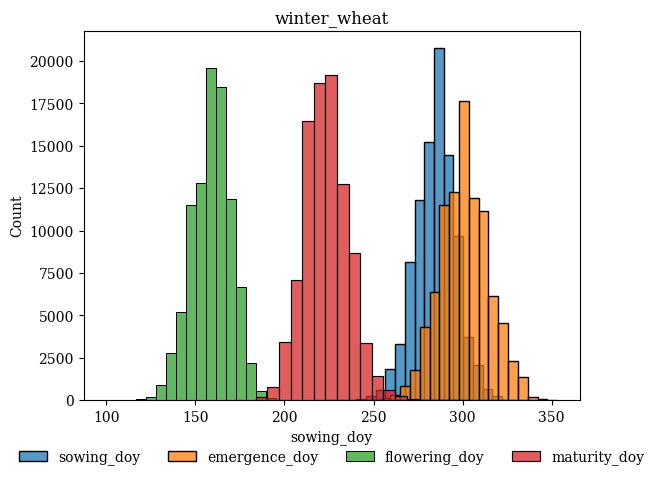

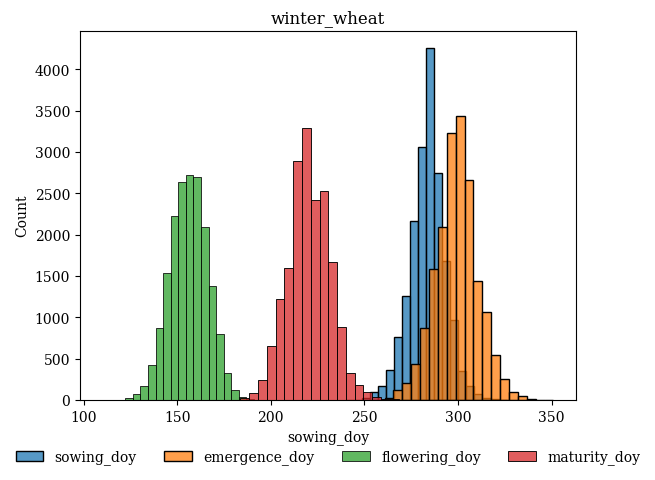

(93036, 11) (90682, 11) (88528, 10) (124763, 10)


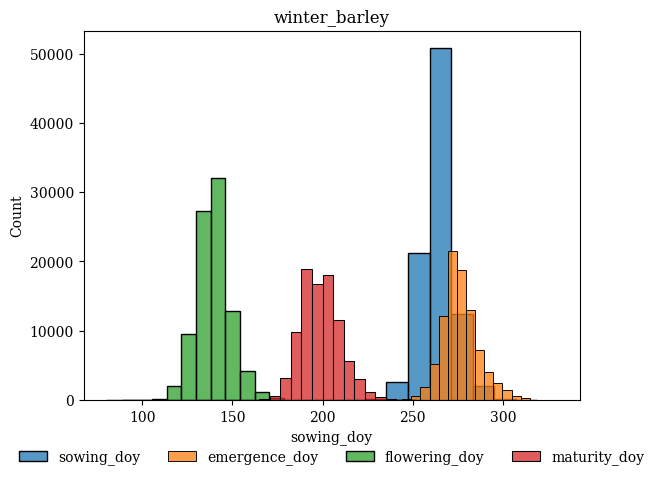

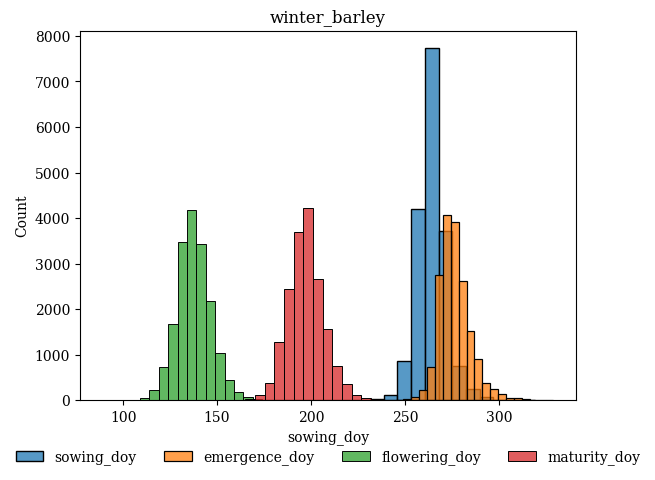

(58368, 11) (58869, 11) (69422, 10) (84648, 10)


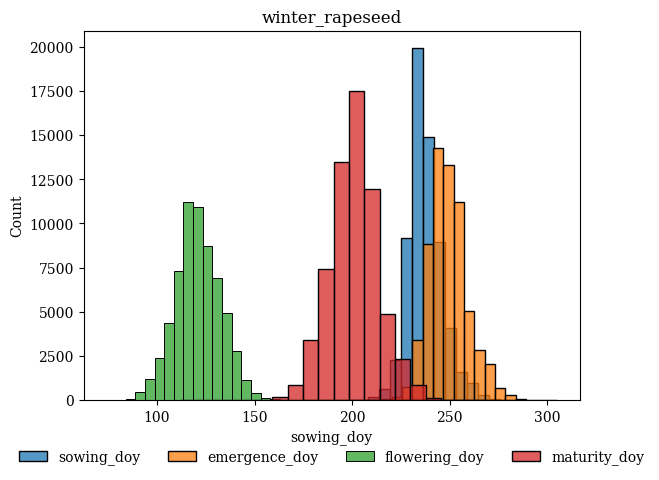

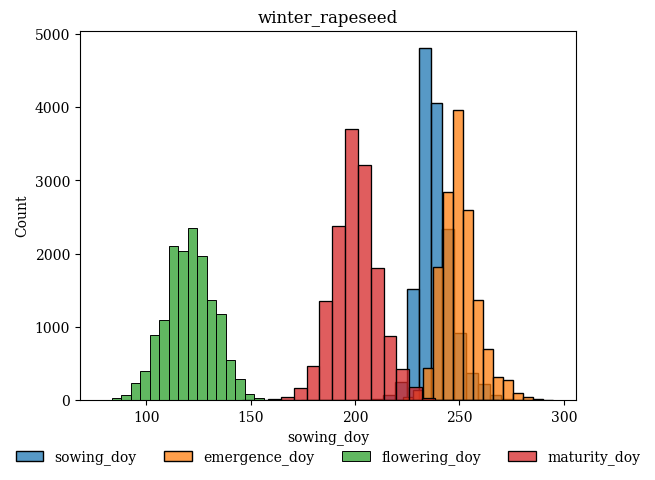

(105070, 11) (100934, 11) (157267, 10) (120617, 10)


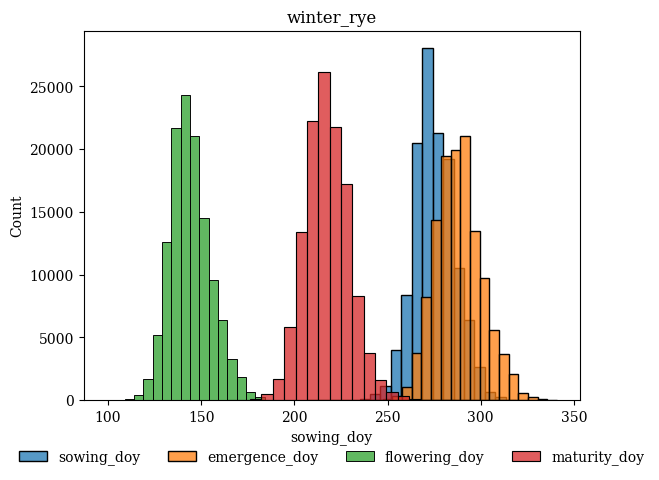

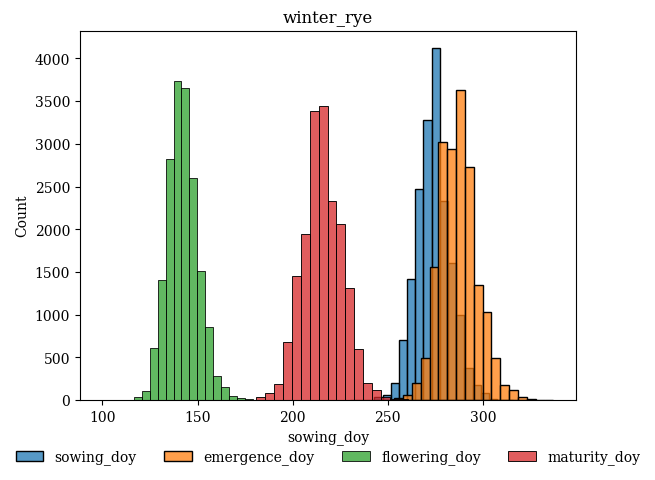

(73231, 11) (70679, 11) (27737, 10) (70421, 10)


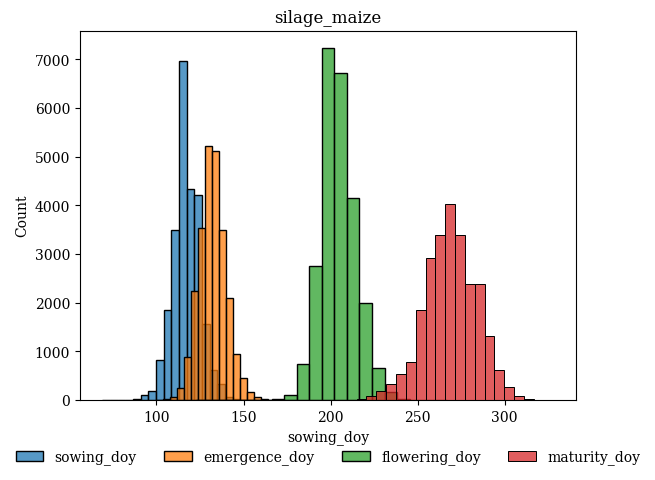

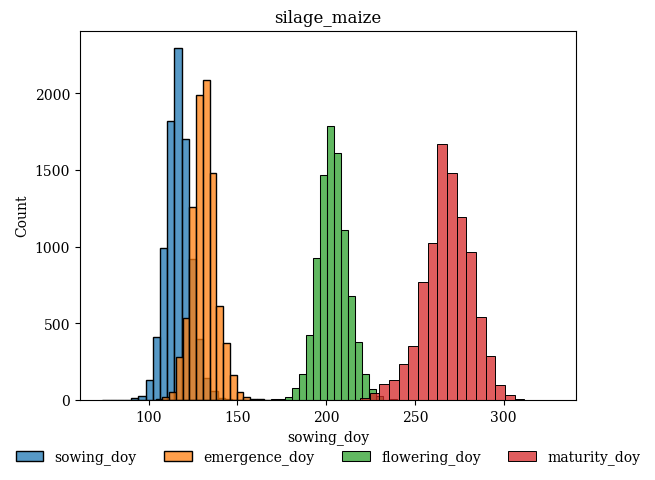

In [4]:
crops = [
    "winter_wheat",
    "winter_barley",
    "winter_rapeseed",
    "winter_rye",
    "silage_maize",
]

de_nuts3_gdf.to_crs(crs="EPSG:25832", inplace=True)
de_nuts1_gdf.to_crs(crs="EPSG:25832", inplace=True)

phen_coords_paths = "/beegfs/halder/GITHUB/RESEARCH/land-surface-phenology/data/phenology_processed_(DE)_all/phenology_stations_(DE).gpkg"
phen_coords = gpd.read_file(phen_coords_paths)
phen_coords.to_crs(crs="EPSG:25832", inplace=True)

phen_coords = gpd.sjoin(
    left_df=phen_coords,
    right_df=de_nuts3_gdf[["NUTS_ID", "NUTS_NAME", "geometry"]],
    how="inner",
    predicate="intersects",
).drop(columns="index_right")

phen_coords = gpd.sjoin(
    left_df=phen_coords,
    right_df=de_nuts1_gdf[["STATE_ID", "STATE_NAME", "geometry"]],
    how="inner",
    predicate="intersects",
).drop(columns="index_right")


for crop in crops:

    phen_df = process_phenology(crop)
    phen_df = pd.merge(
        left=phen_df,
        right=phen_coords[
            ["stations_id", "NUTS_ID", "NUTS_NAME", "STATE_ID", "STATE_NAME"]
        ],
        on="stations_id",
        how="inner",
    )

    nuts_year_mean = (
        phen_df.groupby(
            ["harvest_year", "NUTS_ID", "NUTS_NAME", "STATE_ID", "STATE_NAME"]
        )
        .agg(
            {
                "sowing_date": "mean",
                "sowing_doy": "mean",
                "emergence_date": "mean",
                "emergence_doy": "mean",
                "flowering_date": "mean",
                "flowering_doy": "mean",
                "maturity_date": "mean",
                "maturity_doy": "mean",
            }
        )
        .reset_index()
    )

    doy_cols = ["sowing_doy", "emergence_doy", "flowering_doy", "maturity_doy"]
    nuts_year_mean[doy_cols] = nuts_year_mean[doy_cols].astype(int)

    date_cols = ["sowing_date", "emergence_date", "flowering_date", "maturity_date"]
    for col in date_cols:
        nuts_year_mean[col] = nuts_year_mean[col].dt.strftime("%Y-%m-%d")

    # For plotting
    for c in doy_cols:
        sns.histplot(nuts_year_mean[c], label=c, bins=20)

    plt.title(crop)
    plt.legend(loc="upper center", ncol=4, frameon=False, bbox_to_anchor=(0.5, -0.1))

    plt.savefig(
        os.path.join(OUT_DIR, "figures", "phenology", f"{crop}_phenology.svg"),
        format="svg",
        bbox_inches="tight",
        dpi=300,
    )

    plt.show()
    plt.close()

    output_path = os.path.join(
        "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/data/processed",
        crop,
        f"{crop}_phenology.csv",
    )
    nuts_year_mean.sort_values(by=["NUTS_ID", "harvest_year"], inplace=True)
    nuts_year_mean.to_csv(output_path, index=False)